<a href="https://colab.research.google.com/github/alciopralcio/ML2024/blob/zad2/Usecase2_Gynter_Aleksander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importowanie bibliotek

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Wczytywanie danych o ocenach i filmach z plików CSV

In [18]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')
movies.tail()

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


# Liczba filmów Sci-Fi


In [19]:
sci_fi_count = movies[movies['genres'].str.contains('Sci-Fi')].shape[0]
print(f"Liczba filmów Sci-Fi: {sci_fi_count}")


Liczba filmów Sci-Fi: 980


In [20]:
print(movies.columns)


Index(['movieId', 'title', 'genres'], dtype='object')


# Utworzenie rozkładu ocen komedii dla roku 2017

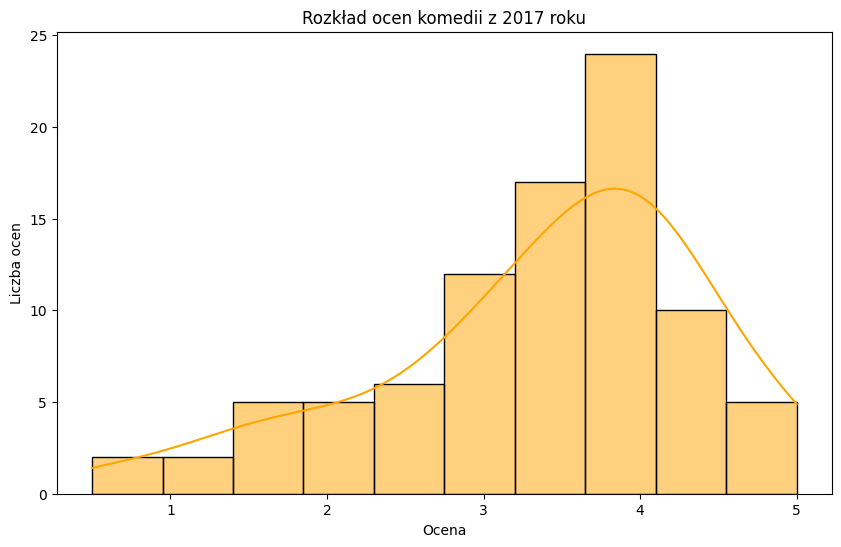

In [25]:
# wyodrębniamy rok z kolumny 'title', przypisujemy do nowo utworzonej 'year'
movies['year'] = movies['title'].str.extract('\((\d{4})\)')

# konwersja kolumny 'year' na typ liczbowy
movies['year'] = pd.to_numeric(movies['year'], errors='coerce')

# połączenie dataframe'ów: ratings i movies
combined = pd.merge(ratings, movies, on='movieId')

# wybór ocen tylko dla komedii z 2017 roku
comedy_2017 = combined[(combined['genres'].str.contains('Comedy')) & (combined['year'] == 2017)]

# utworzenie wykresu rozkładu ocen
plt.figure(figsize=(10,6))
sns.histplot(comedy_2017['rating'], bins=10, kde=True, color='orange')
plt.title('Rozkład ocen komedii z 2017 roku')
plt.xlabel('Ocena')
plt.ylabel('Liczba ocen')
plt.show()

# Analiza filmów akcji

In [26]:
# filmy akcji - info o ocenach
action_movies = combined[combined['genres'].str.contains('Action')]

# obliczenie średniej ocen dla wszystkich filmów akcji
average_rating_action = action_movies['rating'].mean()
print("Średnia ocen dla wszystkich filmów akcji:", average_rating_action)

# znalezienie trzech najczęściej ocenianych filmów akcji
top_action_movies = action_movies.groupby('title').size().sort_values(ascending=False).head(3)
print("\nTrzy najczęściej oceniane filmy akcji:")
for index, value in top_action_movies.items():
    print(index, "- Liczba ocen:", value)


Średnia ocen dla wszystkich filmów akcji: 3.447984331646809

Trzy najczęściej oceniane filmy akcji:
Matrix, The (1999) - Liczba ocen: 278
Star Wars: Episode IV - A New Hope (1977) - Liczba ocen: 251
Jurassic Park (1993) - Liczba ocen: 238


In [28]:
!pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163006 sha256=a9324d3f339ac56d57f56342f5eff723774a8df155f9365a5f7558b2c0fc4c62
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [33]:
from surprise import SVD, KNNBaseline, Dataset, Reader
from surprise.model_selection import cross_validate, GridSearchCV
import numpy as np
import time

# **Część II zadania - system rekomendacyjny**

# Załadowanie danych

In [34]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_builtin('ml-100k')
trainset = data.build_full_trainset()

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


# Losowy wybór dwóch algorytmów

In [35]:
selected_algorithms = np.random.choice(['SVD', 'KNNBaseline'], size=2, replace=False)


# Inicjalizacja algorytmów

In [36]:
if 'SVD' in selected_algorithms:
    svd_algorithm = SVD()
if 'KNNBaseline' in selected_algorithms:
    knn_algorithm = KNNBaseline()

# Dla algorytmu kNN Baseline wykonano hiperparamteryzację

In [40]:

if 'KNNBaseline' in selected_algorithms:
    param_grid = {'k': [2, 3, 4, 5, 6]}
    knn_grid_search = GridSearchCV(KNNBaseline, param_grid, measures=['RMSE', 'MAE'], cv=5, n_jobs=-1)
    start = time.time()
    knn_grid_search.fit(data)
    end = time.time()
    print("Czas uczenia kNN:", end - start)
    if knn_grid_search.best_params is not None:
        print("Najlepsze parametry dla kNN:", knn_grid_search.best_params['rmse'])
    else:
        print("Nie znaleziono najlepszych parametrów dla kNN.")


Czas uczenia kNN: 55.76629114151001
Najlepsze parametry dla kNN: {'k': 6}


In [41]:
# Ocena algorytmów za pomocą walidacji krzyżowej
if 'SVD' in selected_algorithms:
    svd_results = cross_validate(svd_algorithm, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
if 'KNNBaseline' in selected_algorithms:
    knn_results = cross_validate(knn_algorithm, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9427  0.9409  0.9352  0.9339  0.9295  0.9365  0.0048  
MAE (testset)     0.7438  0.7423  0.7376  0.7353  0.7325  0.7383  0.0042  
Fit time          3.00    1.43    2.12    1.42    1.41    1.87    0.62    
Test time         0.79    0.14    0.20    0.24    0.14    0.30    0.25    
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 

## Algorytm kNN Baseline uzyskał nieco lepsze wyniki RMSE oraz MAE niż algorytm SVD, co sugeruje, że jest on skuteczniejszy w przewidywaniu ocen.
SVD ma jednak znacznie krótszy czas dopasowania modelu i testowania modelu niż algorytm kNN Baseline.



# Wyświetlenie wyników oceny

In [43]:
if 'SVD' in selected_algorithms:
    print("\nWyniki SVD:")
    for key, value in svd_results.items():
        print(key, ':', value)
if 'KNNBaseline' in selected_algorithms:
    print("\nWyniki kNN:")
    for key, value in knn_results.items():
        print(key, ':', value)


Wyniki SVD:
test_rmse : [0.94267737 0.94093722 0.93522349 0.93391523 0.92952269]
test_mae : [0.74378148 0.7423115  0.73762705 0.73530348 0.73252044]
fit_time : (3.00068736076355, 1.4254553318023682, 2.1159121990203857, 1.4183197021484375, 1.4145734310150146)
test_time : (0.7883365154266357, 0.1385338306427002, 0.20478200912475586, 0.24338769912719727, 0.1424572467803955)

Wyniki kNN:
test_rmse : [0.92747809 0.92695813 0.92921022 0.94085396 0.92753006]
test_mae : [0.72928007 0.7306714  0.73102558 0.7419946  0.73180058]
fit_time : (0.7390625476837158, 0.7694318294525146, 0.7788398265838623, 0.8589515686035156, 0.7896780967712402)
test_time : (3.8158822059631348, 4.8635382652282715, 4.338960409164429, 7.024736166000366, 3.6717631816864014)


# Algorytm kNN Baseline wydaje się być bardziej dokładny, ale wymaga więcej czasu na przetwarzanie niż algorytm SVD. Warto więc rozważyć wybór SVD gdy jesteśmy ograniczeni czasowo